In [1]:
import seaborn as sns
import pandas as pd
pd.set_option("display.max_columns", None)
import matplotlib
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from biodatatools.utils.common import json_load
from biodata.delimited import DelimitedWriter
import pybedtools
from scipy.stats import zscore
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as sch
from pathlib import Path

In [2]:
font_dir = Path.cwd().parent / "font"
for font in ["Arial.ttf", "Arial_Bold.ttf"]:
    matplotlib.font_manager.fontManager.addfont(font_dir / font)
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9
lw = 0.8

In [3]:
PROJECT_DIR_d = "/home/yc2553/projects/HEA/databases/"
PROJECT_DIR_d2 = "/fs/cbsuhy02/storage/yc2553/yc2553/databases/"
PROJECT_DIR_o = "/home/yc2553/projects/HEA/output/"

# Hierarchical clustering

In [25]:
# Check the relationship between ESC/iPSC panel and adult tissues

labels = json_load(f"{PROJECT_DIR_d}PROcap/metainfo/classifications.json")

In [26]:
groups = json_load(f"{PROJECT_DIR_d}PROcap/metainfo/samples.json")
all_samples = groups["normal_tissues"] + groups["lineage_differentiation"]

In [6]:
metafile = f"{PROJECT_DIR_o}tables/SuppTable1.xlsx"
df_metrics = pd.read_excel(metafile, sheet_name=2)
reads = {}
for _, row in df_metrics.iterrows():
    reads[row["PRO-cap sample ID"]] = row["Uniquely mapped, deduplicated read pairs"]

In [27]:
samples = [s for s in all_samples if reads[s] >= 10e6]
len(samples)

139

In [19]:
df_exp = pd.read_table(f"{PROJECT_DIR_d}PROcap/processed/norm_reads_vst_all.txt", index_col=0)

In [28]:
p = "divergent"
d = "distal"
df = pd.read_table(f"{PROJECT_DIR_d}PROcap/processed/binary_{p}_{d}.txt", index_col=0)
es = list(df[df[samples].sum(axis=1) >= 1].index)

In [30]:
pca = PCA(n_components=0.9, random_state=42)
pcs = pca.fit_transform(df_exp.loc[es][samples].T)
df_pca = pd.DataFrame(pcs, index=samples)

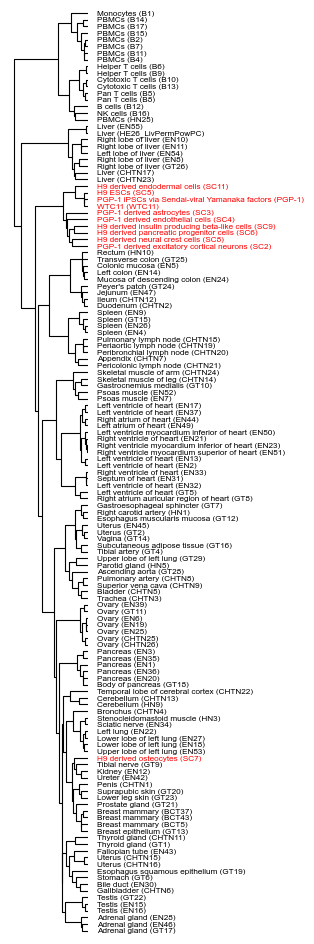

In [57]:
Z = sch.linkage(df_pca, metric='euclidean', method='ward')
fig, ax = plt.subplots(figsize=(1,12))
dendro = sch.dendrogram(Z, labels=[f"{labels[s][0]} ({s})" for s in samples], leaf_rotation=0, orientation="left", color_threshold=0, link_color_func=lambda k: "black")
for line in ax.collections:
	line.set_linewidth(lw)

ax.spines[['top','bottom','left', 'right']].set_visible(False)
ax.xaxis.set_visible(False)

ax.invert_yaxis()
highlight = [f"{labels[s][0]} ({s})" for s in groups["lineage_differentiation"]]
for label in ax.get_yticklabels():
	text = label.get_text()
	label.set_fontsize(5.9)
	if text in highlight:
		label.set_color("r") 

outputfile = f"{PROJECT_DIR_o}figures/ExtDataFig4a.pdf"
plt.savefig(outputfile, bbox_inches='tight', transparent=True)

# VISTA enhancers

In [ ]:
# Paper: https://academic.oup.com/nar/advance-article/doi/10.1093/nar/gkae940/7848837
# Website: https://enhancer.lbl.gov/vista/
# The database is updated regularly — be sure to note the download date
# As of 5/20/2025, the database contains information on 4651 in vivo tested elements - 2307 elements with enhancer activity.
# https://gitlab.com/egsb-mfgl/vista-data/-/raw/main/experiments.tsv.gz

In [8]:
date = "20241202"
inputfile = f"{PROJECT_DIR_d2}papers/39470740/experiments_{date}.tsv.gz"
df_info = pd.read_table(inputfile)
df_info.head(2)

,exp_hier,vista_id,allele_id,backbone,stage,curation_status,description,denominator,tissue,tissue_positive,organism,assembly,coord,strand,coordinate_hg38,coordinate_mm10,bracket_hg38,bracket_mm10,seq_hg38,seq_mm10,seq,external_note
0,03vn00010001,hs1,0,hZR,e11.5,positive,reference,15.0,lb;hb;nt;cn,3;12;12;8,Human,hg38,chr16:86396481-86397120,+,chr16:86396481-86397120,chr8:121002895-121003512,IRF8-FOXF1,Gm20388 (intragenic),AACTGAAGGGACCCCGTTAGCATATAAACAAAAGGTGGGGGGTAGC...,AGTTGAGCGACCCTGTTAACGTATAAACAAAAGGTGGGGGGTAACC...,AACTGAAGGGACCCCGTTAGCATATAAACAAAAGGTGGGGGGTAGC...,NaN
1,03v300010001,hs2,0,hZR,e11.5,negative,reference,NaN,NaN,NaN,Human,hg38,chr16:85586489-85588130,+,chr16:85586489-85588130,chr8:120516455-120517853,GSE1 (intragenic),Gm20388 (intragenic),GGCCCTGGTATGTTTGTTCTTCCAGGGGCTCCCAGGATGGATCCAG...,ATATTGGCTCCTACAGGGGCTCCAGGATCATTCCCTGCCCTCCTGG...,GGCCCTGGTATGTTTGTTCTTCCAGGGGCTCCCAGGATGGATCCAG...,NaN


In [9]:
# Field description
# https://gitlab.com/egsb-mfgl/vista-data/-/raw/main/field_descriptions.tsv
# seq --> sequence

inputfile = f"{PROJECT_DIR_d2}papers/39470740/field_descriptions.tsv"
df = pd.read_table(inputfile)
df2 = df[df["table"] == "EXPERIMENT"].copy()
df2["var_name"] = pd.Categorical(df2["var_name"], categories=list(df_info.columns), ordered=True)
df2 = df2.sort_values(by="var_name")
with pd.option_context("display.max_colwidth", None):
    display(df2)

,var_name,table,hierarchy,type,description
21,exp_hier,EXPERIMENT,EXPERIMENT,string,12 digit unique EXPERIMENT identifier (36-base); unique combination of assembly+coord+seq+backbone+stage
8,vista_id,EXPERIMENT,LOCUS,string,"LOCUS identifier (unique assembly+coord); number prefixed with hs (hg38), mm (mm10) or x (other assemblies)"
10,allele_id,EXPERIMENT,ELEMENT,number,ELEMENT identifier (assembly+coord+seq)
14,backbone,EXPERIMENT,EXPERIMENT,string,Plasmid backbone / transgenic method with which the element was tested
15,stage,EXPERIMENT,EXPERIMENT,string,Embryonic stage at which the experiment was terminated
16,curation_status,EXPERIMENT,EXPERIMENT,string,Experiment-level curation outcome (positive or negative; empty for purely allelic curations)
13,description,EXPERIMENT,ELEMENT,string,"Description of the allele, e.g. 'reference' or 'large deletion'"
20,denominator,EXPERIMENT,EXPERIMENT,number,Number of eligible transgenic embryos forming the denominator of numbers in tissue_positive
18,tissue,EXPERIMENT,EXPERIMENT,string,Semicolon-separated list of abbreviations of tissue names (see tissue.dictionary.csv)
19,tissue_positive,EXPERIMENT,EXPERIMENT,string,Semicolon-separated list of numbers of embryos positive for the tissue


In [10]:
# Tissue mapping
# https://gitlab.com/egsb-mfgl/vista-data/-/raw/main/tissue.dictionary.csv

mapping = {}
inputfile = f"{PROJECT_DIR_d2}papers/39470740/tissue.dictionary.csv"
df = pd.read_csv(inputfile)
for _, row in df.iterrows():
	mapping[row["tissue.abb"]] = row["tissue.short"]
len(mapping), mapping

(22,
 {'ba': 'branchial arch',
  'hb': 'hindbrain',
  'eye': 'eye',
  'fb': 'forebrain',
  'nt': 'neural tube',
  'mb': 'midbrain',
  'nose': 'nose',
  'lb': 'limb',
  'cn': 'cranial nerve',
  'drg': 'dorsal root ganglion',
  'ht': 'heart',
  'tri': 'trigeminal ganglion',
  'som': 'somite',
  'gen': 'genital tubercle',
  'mel': 'melanocytes',
  'tail': 'tail',
  'fm': 'facial mesenchyme',
  'other': 'other',
  'ear': 'ear',
  'lv': 'liver',
  'bv': 'blood vessels',
  'pan': 'pancreas'})

In [11]:
# Summary statistics
# Reference elements are typically assigned a zero (“hs200.0”)

Counter(df_info["organism"]), Counter(df_info["allele_id"])

(Counter({'Human': 2894,
          'Mouse': 1723,
          'Iberian mole': 5,
          'Chimp': 4,
          'Burmese python': 2,
          'X. tropicalis': 1,
          'Lancelet': 1,
          'Fugu': 1,
          'Coelacanth': 1,
          'Elephant shark': 1,
          'Speckled rattlesnake': 1,
          'Horse': 1,
          'Cow': 1,
          'Chicken': 1,
          'Platypus': 1,
          'Megabat': 1,
          'Bottlenose Dolphin': 1,
          'Sloth': 1,
          'Lizard': 1,
          'King cobra': 1,
          'Boa constrictor': 1,
          'Cat': 1,
          'D. melanogaster': 1}),
 Counter({0: 4268,
          1: 128,
          2: 44,
          3: 29,
          4: 18,
          5: 10,
          6: 6,
          7: 2,
          8: 1,
          9: 1,
          10: 1,
          11: 1,
          12: 1,
          13: 1,
          14: 1,
          15: 1,
          16: 1,
          17: 1,
          18: 1,
          19: 1,
          20: 1,
          21: 1,
          22: 1,

In [12]:
# Criteria: human, ref allele, regardsless of plasmid backbone/transgenic method/embryonic stage

df_filtered = df_info[(df_info["organism"]=="Human") & (df_info["allele_id"]==0)]
Counter(df_filtered["curation_status"]), Counter(df_filtered["backbone"]), Counter(df_filtered["stage"])

(Counter({'positive': 1346, 'negative': 1186}),
 Counter({'hZR': 1994, 'sZH': 519, 'nZH': 13, 'hZTR': 6}),
 Counter({'e11.5': 2301,
          'e12.5': 144,
          'e14.5': 30,
          'e13.5': 27,
          'e9.5': 14,
          'e15.5': 12,
          'e10.5': 4}))

In [10]:
# Rewrite as a bed file for downstream analysis
# It's not included in the folder I give you as you can generate this file using codes below

outputfile = f"{PROJECT_DIR_d2}papers/39470740/elements_hg38.bed"
with DelimitedWriter(outputfile) as dw:
	for _, row in df_filtered.iterrows():
		chrom = row["coord"].split(":")[0]
		start, end = row["coord"].split(":")[1].split("-")
		if row["curation_status"] == "positive":
			label = ";".join([mapping[t] for t in row["tissue"].split(";")])
		else:
			label = "negative"
		dw.write([chrom, start, end, label, row["vista_id"]])
b = pybedtools.BedTool(outputfile)
b.sort().saveas(outputfile)

<BedTool(/fs/cbsuhy02/storage/yc2553/yc2553/databases/papers/39470740/elements_hg38.bed)>

# PRO-cap vs. VISTA elements

In [13]:
# Only focus on PRO-cap elements found in these samples

es2 = set()
ds = ["distal", "proximal"]
samples2 = [s for s in groups["lineage_differentiation"] if s in samples]
for d in ds:
    df = pd.read_table(f"{PROJECT_DIR_d}PROcap/processed/binary_{p}_{d}.txt", index_col=0)
    es2 |= set(df[df[samples2].sum(axis=1) >= 1].index)

In [14]:
# Get PRO-cap elements overlapping with any VISTA elements in a given category

categories = defaultdict(set)
for d in ds:
    b1 = pybedtools.BedTool(f"{PROJECT_DIR_d}PROcap/processed/merged_{p}_{d}.bed.bgz")
    b2 = pybedtools.BedTool(f"{PROJECT_DIR_d2}papers/39470740/elements_hg38.bed")
    # f: Minimum overlap required as a fraction of A
    overlap = b1.intersect(b2, wao=True, f=0.5)
    for i in overlap:
        if int(i.fields[-1]) > 0:
            # PRO-cap elements
            e = "_".join(i.fields[:3])
            if e in es2:
                # VISTA category: negative or tissue types
                ts = i.fields[-3].split(";")
                for t in ts:
                    categories[t].add(e)

In [15]:
for t in categories:
    print(t, len(categories[t]))

negative 257
branchial arch 59
facial mesenchyme 31
nose 25
limb 69
neural tube 151
eye 36
forebrain 189
somite 33
hindbrain 202
heart 138
midbrain 206
other 85
dorsal root ganglion 61
trigeminal ganglion 53
tail 8
cranial nerve 61
ear 19
blood vessels 22
liver 10
genital tubercle 7
melanocytes 4
pancreas 6


In [16]:
# Focus on relevant tissue types

index =  ['pancreas', 'blood vessels', 
          # Derived from neural crest
          'dorsal root ganglion', 'trigeminal ganglion', 'cranial nerve', 
          # Derived from neural tube
          'neural tube', 'forebrain', 'midbrain', 'hindbrain', 
          'negative'
         ]

In [17]:
columns = ["WTC11", "PGP-1", "SC5", 
           "SC11", "SC6", "SC9",
           "SC4", 
           "SC8", "SC2", 
           "SC7", "SC3"
           ]

In [20]:
# Get zscores

df_zscore = df_exp[samples2].loc[list(es2)].apply(zscore, axis=1)

In [21]:
# Generate matrix for heatmap

results = []
for t in index:
    results.append(df_zscore.loc[list(categories[t])][columns].mean())
df_heatmap = pd.DataFrame(results, index=[i.capitalize() for i in index])
renamed_columns = []
for c in columns:
    if c in ["WTC11", "PGP-1"]:
        renamed_columns.append(f"{labels[c][1]} ({c})")
    elif c == "SC5":
        renamed_columns.append(f"{labels[c][1]} (H9)")
    else:
        renamed_columns.append(labels[c][0].split("derived ")[1].capitalize())
df_heatmap.columns = renamed_columns
df_heatmap.head(2)

,iPSCs (WTC11),iPSCs (PGP-1),ESCs (H9),Endodermal cells,Pancreatic progenitor cells,Insulin producing beta-like cells,Endothelial cells,Neural crest cells,Excitatory cortical neurons,Osteocytes,Astrocytes
Pancreas,-0.408576,-0.435874,-0.694437,-0.101364,1.619753,0.758338,0.120417,-0.593875,-0.760207,-0.022888,0.518713
Blood vessels,-0.148368,-0.130356,-0.120526,-0.045789,-0.090140,-0.624797,1.750747,0.462625,-0.580718,-0.764649,0.291970


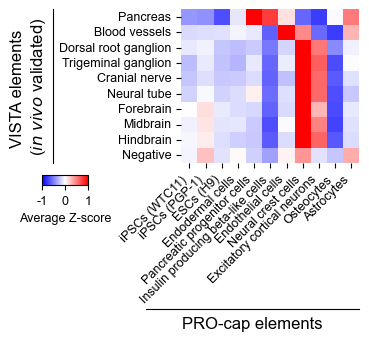

In [22]:
fig, ax = plt.subplots(figsize=(2.3,2))
vlims=(-1,0,1)
g = sns.heatmap(df_heatmap, vmin=vlims[0], vmax=vlims[-1], 
                xticklabels=True, cmap="bwr", cbar=False, ax=ax)
g.set_xticklabels(g.get_xticklabels(), rotation=45, ha='right')
g.tick_params(labelsize=sfontsize)

cbar_ax = fig.add_axes([-0.48, 0, 0.2, 0.05])
cbar = plt.colorbar(g.collections[0], cax=cbar_ax, orientation="horizontal")
cbar.set_ticks(vlims)
cbar.set_ticklabels(vlims)
cbar.ax.tick_params(labelsize=sfontsize) 
cbar.set_label("Average Z-score", fontsize=sfontsize)

g.set_ylabel("VISTA elements \n($in$ $vivo$ validated)", fontsize=bfontsize, labelpad=8)
line_x = -0.72
g.plot([line_x, line_x], [0, 1], transform=g.transAxes, c="black", clip_on=False, lw=lw)
g.set_xlabel("PRO-cap elements", fontsize=bfontsize, x=0.4, labelpad=8)
line_y = -0.95
g.plot([-0.2, 1], [line_y, line_y], transform=g.transAxes, c="black", clip_on=False, lw=lw)

plt.savefig(f"{PROJECT_DIR_o}figures/Fig2e.pdf", bbox_inches='tight', transparent=True)